# Analyze Eye Tracker Data

We will use {cite:p}`mathot_methods_2022`

## Preliminaries

## Eyelink Parser

We will use the recent fork of `python_eyelinkparser` module.

In [1]:
!pip install git+https://github.com/maciejskorski/python-eyelinkparser.git

  Cloning https://github.com/maciejskorski/python-eyelinkparser.git to /tmp/pip-req-build-uj2hrv0p
  Running command git clone --filter=blob:none --quiet https://github.com/maciejskorski/python-eyelinkparser.git /tmp/pip-req-build-uj2hrv0p
  Resolved https://github.com/maciejskorski/python-eyelinkparser.git to commit dd11919b56be71ae31fa5d6e4334cc91508fe09e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-eyelinkparser: filename=python_eyelinkparser-0.18.0-py3-none-any.whl size=1727261 sha256=a522b06db73bd328824c24b78f937c94e1d3ae65f1514467ac9198e5ad513cfc
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg46rtba/wheels/9d/0c/5c/9d6e11d7b4aad80d34ea5686ba0a875358c6815ebfa8b5c96e
Successfully built python-eyelinkparser

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


## Dataset

In [ ]:
import pkg_resources
edf2asc_path = pkg_resources.resource_filename('python_eyelinkparser', "utils/converter")

!wget -O awm.edf https://github.com/smathot/pupillometry_review/blob/master/data/auditory%20working%20memory/data/awm.edf?raw=true
!{edf2asc} awm.edf -Y

--2022-08-07 12:23:09--  https://github.com/smathot/pupillometry_review/blob/master/data/auditory%20working%20memory/data/awm.edf?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/smathot/pupillometry_review/raw/master/data/auditory%20working%20memory/data/awm.edf [following]
--2022-08-07 12:23:09--  https://github.com/smathot/pupillometry_review/raw/master/data/auditory%20working%20memory/data/awm.edf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/smathot/pupillometry_review/master/data/auditory%20working%20memory/data/awm.edf [following]
--2022-08-07 12:23:09--  https://raw.githubusercontent.com/smathot/pupillometry_review/master/data/auditory%20working%20memory/data/awm.edf
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [18]:
from datamatrix import (
  operations as ops,
  functional as fnc,
  series as srs
)
from python_eyelinkparser.eyelinkparser import parse, defaulttraceprocessor

@fnc.memoize(persistent=True)
def get_data():

    # The heavy lifting is done by eyelinkparser.parse()
    dm = parse(
        folder='./',           # Folder with .asc files
        traceprocessor=defaulttraceprocessor(
          blinkreconstruct=True, # Interpolate pupil size during blinks
          downsample=10,         # Reduce sampling rate to 100 Hz,
          mode='advanced'        # Use the new 'advanced' algorithm
        )
    )
    # To save memory, we keep only a subset of relevant columns.
    dm = dm[dm.set_size, dm.correct, dm.ptrace_sounds, dm.ptrace_retention, 
            dm.fixxlist_retention, dm.fixylist_retention]
    return dm

dm = get_data()

In [19]:
print(dm)

+----+---------+---------------------------+---------------------------+-----------------------------------+-----------------------------------+----------+
| #  | correct |     fixxlist_retention    |     fixylist_retention    |          ptrace_retention         |           ptrace_sounds           | set_size |
+----+---------+---------------------------+---------------------------+-----------------------------------+-----------------------------------+----------+
| 0  |    1    | [525.9 527.1 ... nan nan] | [382.9 380.4 ... nan nan] | [1810.  1810.3 ... 1902.9 1908.2] |    [1655.6 1657.1 ... nan nan]    |    5     |
| 1  |    1    | [528.9 526.8 ... nan nan] | [386.4 387.5 ... nan nan] | [1644.6 1648.7 ... 1675.4 1673.4] |    [1717.3 1718.5 ... nan nan]    |    3     |
| 2  |    1    | [521.4 524.2 ... nan nan] | [377.3 371.4 ... nan nan] | [1787.  1791.4 ... 1719.9 1719.3] | [1471.8 1470.4 ... 1783.2 1785.3] |    7     |
| 3  |    1    | [523.2 520.7 ... nan nan] | [382.6 390.7 ... na

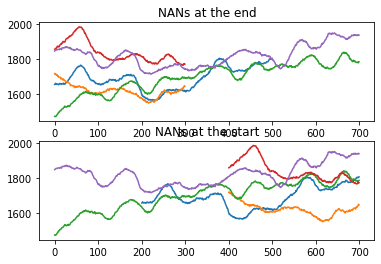

In [4]:
from matplotlib import pyplot as plt
from datamatrix import series as srs

plt.figure()
plt.subplot(211)
plt.title('NANs at the end')
for pupil in dm.ptrace_sounds[:5]:
    plt.plot(pupil)
plt.subplot(212)
plt.title('NANs at the start')
for pupil in srs.endlock(dm.ptrace_sounds[:5]):
    plt.plot(pupil)
plt.show()

In [5]:
dm.pupil = srs.concatenate(
    srs.endlock(dm.ptrace_sounds),
    dm.ptrace_retention
)
dm.pupil = srs.baseline(
    series=dm.pupil,
    baseline=dm.ptrace_sounds,
    bl_start=0,
    bl_end=2
)

In [6]:
dm.pupil.depth = 1200

/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ubuntu/projects/eye-processing/.venv/lib/python3.10/site-packages/datamatrix/_datamatrix/_seriescolumn.py:130: RuntimeWarning: Mean of empty slice
  return nanmean(self._seq, axis=0)


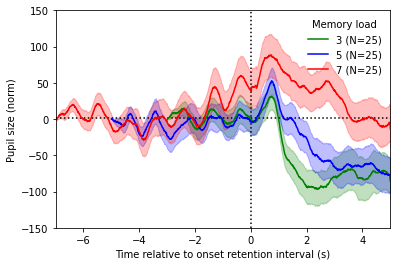

In [7]:
import numpy as np


def plot_series(x, s, color, label):

    se = s.std / np.sqrt(len(s))
    plt.fill_between(x, s.mean-se, s.mean+se, color=color, alpha=.25)
    plt.plot(x, s.mean, color=color, label=label)


x = np.linspace(-7, 5, 1200)
dm3, dm5, dm7 = ops.split(dm.set_size, 3, 5, 7)

plt.figure()
plt.xlim(-7, 5)
plt.ylim(-150, 150)
plt.axvline(0, linestyle=':', color='black')
plt.axhline(1, linestyle=':', color='black')
plot_series(x, dm3.pupil, color='green', label='3 (N=%d)' % len(dm3))
plot_series(x, dm5.pupil, color='blue', label='5 (N=%d)' % len(dm5))
plot_series(x, dm7.pupil, color='red', label='7 (N=%d)' % len(dm7))
plt.ylabel('Pupil size (norm)')
plt.xlabel('Time relative to onset retention interval (s)')
plt.legend(frameon=False, title='Memory load')
plt.show()